In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# What is style transfer and how does it work?

In [ ]:
''' The Gram matrix (feature activation covariance)

* Interpreting a covariance matrix
- A covariance matrix contains all pairwise interactions between the features.
- It reflects patterns (interactions) that are distributed across the features.
- Covariance matrix is the basis for PCA, factor analysis, linear discriminant analysis, NNMF, and other dimension-reduction methods.
- In Style transfer, the features covariance matrix encodes a higher-level feature-interaction space;
  a combination of many features.

* The Gram matrix
- Scaling by 1/N is used to normalize for differences in feature map size across convolution layers.

* Interpreting a Gram matrix
- Main point: A Gram matrix is basically the same thing as a covariance matrix (key difference is mean-centering).
- So, you interpret a Gram matrix the same way you interpret a covariance matrix:
  A representation of all linear interactions across all pairs of features.
- Specifically for CNNs: The Gram matrix represents the "texture" or style of the image, not the individual pixels.

* Flattening a 3D feature cube to a 2D map
- Features X Width X Height -> Features X (Width x Height)

'''

# The style transfer algorithm

In [ ]:
'''
* The procedure for implementing style transfer.

1) Step 1 : Trainable random noise (Create the target image as random numbers and make it trainable.)
  - Don't train the network.
  - "Train" the image!
  - Backprop will slowly transform the target image.

2) Step 2 : Pick a pretrained CNN network

3) Step 3 : Match content ("pixel-level" feature mapping)
  - We want to train the pixel level features from the content image.
  - The loss funciton here is the MSE, the mean squared error between the content image feature maps and the target image feature maps.
  - Early in training, the target image feature maps are just pure noise, so this error is going to be large.
  - But then the idea is that over training, the target image will start to look more and more like the content image to minimize this loss funciton.
  - Now key here is that we want the target image to look like the content image.
  - So we want to match the target image to the activation maps early in the network.
  - Generally you want to match to the first or the first few layers and not really the later layers in the network.
  - That's because the later layers contain more abstract acted representations of the original image.
  - If we went up to step three, if we stopped our algorithm here, then it would be pretty trivial that after a bunch of iterations,
    the target image would simply be a close approximation to the content image.
  - So therefore we go on to step four, which is to match the style.

4) Step 4 : Match style ("texture-level" feature mapping)
  - Here we are using the style image, not the content image.
  - We do not actually care about the images per se or the feature maps per se.
  - Instead, we are interested in matching the gram matrices, which encode the higher level statistics about the relationships,
    the correlational patterns across the different pixels, and that is what gives us the texture or the style of the images and
    not the individual pixel intensity values.
  - So therefore we also using the loss funciton.
  - MSE mean squared error, but not what we are matching across the different layers of the convolutional network is
    the gram matrices from the style image with the gram matrices from the target image.

* Overview of the style transfer algorithm

1) First stage: Preparation
  - Import and freeze a pretrained CNN.
  - Import and transform images.
  - Make a trainable target image using random numbers.
  - Functions to compute feature maps and Gram matrices.

2) Second stage (Loop over N epochs)
  - Extract target feature activation maps
  - contentMSE: target vs. content
  - Compute Gram of target feature maps     (loop over layers)
  - styleMSE: of target Gram vs. styleGram  (loop over layers)
  - Loss: contentMSE + styleMSE
  - Backprop on target image

* Meta-paramters to consider
  - Meta-parameter: Effect on style transfer.
  - Number of training epcohs: More epochs -> more refinement.
  - Layer(s) for content-matching: Earlier layers -> more details preserved.
  - Layer(s) and weights for style: Later layers -> more abstracted style.
  - Style loss gain factor: Strength of style transfer.
  - Model architecture: e.g., mean-pool instead of max-pool.

=> There is no quantitative optimum; "good" results are subjective preferences.

'''

# Transferring the screaming bathtub

In [ ]:
''' style transfer using the pretrained VGG19 net. '''

## Import VGG19 and freeze all layers

In [3]:
# import the model
vggnet = torchvision.models.vgg19(pretrained=True)

# freeze all layers
for p in vggnet.parameters():
    p.requires_grad=False

# set to evaluation mode
vggnet.eval()

# send the network to the GPU
vggnet.to(device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 80.2MB/s]


In [8]:
vggnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Import two images

In [4]:
from imageio import imread

img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0, high=255, size=img4content.shape, dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

<ipython-input-4-7390d755ec4a>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
<ipython-input-4-7390d755ec4a>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')


(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [5]:
# These images are really large, which wll make training take a long time

# create the transforms
Ts = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts(img4content).unsqueeze(0).to(device)
img4style = Ts(img4style).unsqueeze(0).to(device)
img4target = Ts(img4target).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


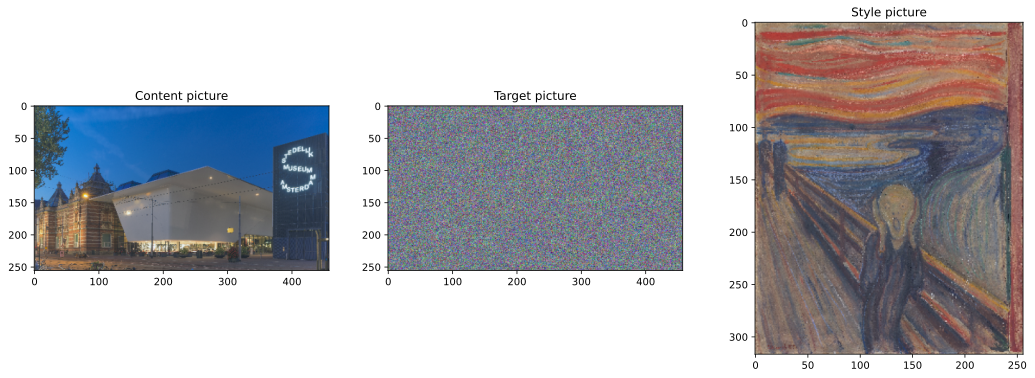

In [7]:
# Let's have a look at the "before" pics
fig, ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

## Functions to extract image feature map activations

In [12]:
# A function that returns feature maps
def getFeatureMapActs(img, net):

    # initialize feature maps as a list
    featuremaps = []
    featurenames = []

    convLayerIdx = 0

    # loop through all layers in the "feature" block
    for layernum in range(len(net.features)):

        # print out info from this layer
        # print(layernum, net.features[layernum])

        # process the image through this layer
        img = net.features[layernum](img)

        # store the image if it's a conv2d layer
        if "Conv2d" in str(net.features[layernum]):
            featuremaps.append(img)
            featurenames.append('ConvLayer_' + str(convLayerIdx))
            convLayerIdx += 1

    return featuremaps, featurenames

In [16]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(M):

    # reshape to 2D
    _, chans, height, width = M.shape
    M = M.reshape(chans, height*width)

    # compute and return covariance matrix
    gram = torch.mm(M, M.t()) / (chans*height*width)
    return gram

In [11]:
# inspect the output of the funciton
featmaps, featnames = getFeatureMapActs(img4content, vggnet)

print()

# print out some info
for i in range(len(featnames)):
    print('Feature map "%s" is size %s' %(featnames[i], (featmaps[i].shape)) )

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

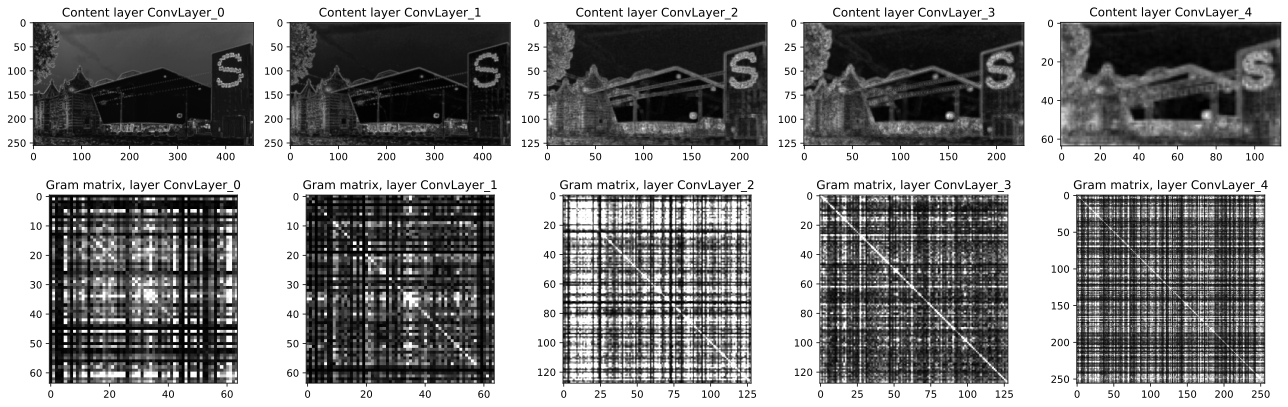

In [18]:
# let's see what the "content" image looks like
contentFeatureMaps, contentFeatureNames = getFeatureMapActs(img4content, vggnet)

fig, axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy(), axis=0 )
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0,i].imshow(pic, cmap='gray')
    axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))

    # now show the gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[1,i].imshow(pic, cmap='gray', vmax=.1)
    axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

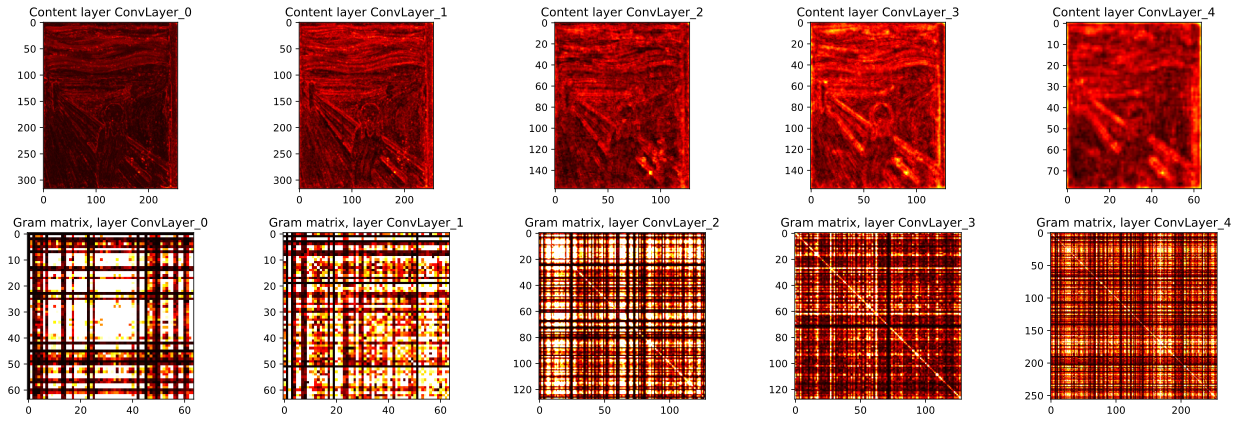

In [20]:
# repeat for the "style" image
styleFeatureMaps, styleFeatureNames = getFeatureMapActs(img4style, vggnet)

fig, axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy(), axis=0 )
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0,i].imshow(pic, cmap='hot')
    axs[0,i].set_title('Content layer ' + str(styleFeatureNames[i]))

    # now show the gram matrix
    pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[1,i].imshow(pic, cmap='hot', vmax=.1)
    axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

## Now for the transfer

In [29]:
# which layers to use
layers4content = [ 'ConvLayer_1','ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ]

In [30]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]


  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()

## Let's have a looksie!

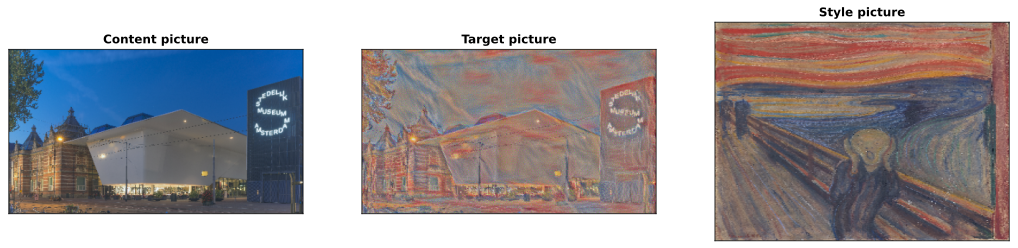

In [31]:
# the "after" pic

fig, ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture', fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture', fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

# Style transfer with AlexNet

## Import AlexNet and freeze all layers

In [3]:
# import the model
alexnet = torchvision.models.alexnet(pretrained=True)

# freeze all layers
for p in alexnet.parameters():
    p.requires_grad=False

# set to evaluation mode
alexnet.eval()

# send the network to the GPU
alexnet.to(device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 42.4MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Import two images

In [7]:
from imageio import imread

img4content = imread('https://images-na.ssl-images-amazon.com/images/I/61A6DiLZeWL.jpg')
img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/d/d4/Abstract_stained_glass_window_in_cathedral_of_St._Charles_Borromeo_in_Ciudad_Quesada.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0, high=255, size=img4content.shape, dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

<ipython-input-7-1bc84d3a614a>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('https://images-na.ssl-images-amazon.com/images/I/61A6DiLZeWL.jpg')
<ipython-input-7-1bc84d3a614a>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/d/d4/Abstract_stained_glass_window_in_cathedral_of_St._Charles_Borromeo_in_Ciudad_Quesada.jpg')


(500, 750, 3)
(500, 750, 3)
(4126, 3240, 3)


In [8]:
# These images are really large, which wll make training take a long time

# create th transforms
Ts = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts(img4content).unsqueeze(0).to(device)
img4style = Ts(img4style).unsqueeze(0).to(device)
img4target = Ts(img4target).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 256, 384])
torch.Size([1, 3, 256, 384])
torch.Size([1, 3, 326, 256])


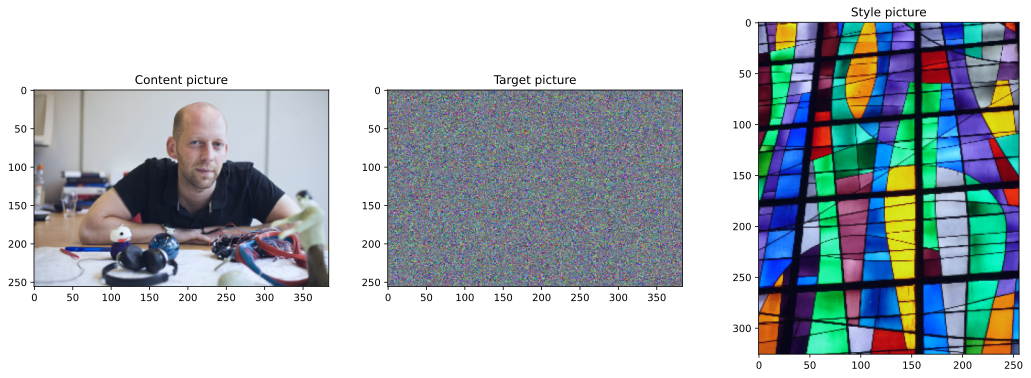

In [10]:
# Let's have a look at the "before" pics
fig, ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

## Functions to extract image feature map activations

In [16]:
# A function that returns feature maps

def getFeatureMapActs(img, net):

    # initialize feature maps as a list
    featuremaps = []
    featurenames = []

    convLayerIdx = 0

    # loop through all layers in the "feature" block
    for layernum in range(len(net.features)):

        # print out info from this layer
        # print(layernum, net.features[layernum])

        # process the image through this layer
        img = net.features[layernum](img)

        # store the image is it's a conv2d layer
        if 'Conv2d' in str(net.features[layernum]):
            featuremaps.append(img)
            featurenames.append('ConvLayer_' + str(convLayerIdx))
            convLayerIdx += 1

    return featuremaps, featurenames

In [12]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(F):

    # reshape to 2D
    _, chans, height, width = F.shape
    F = F.reshape(chans, height*width)

    # compute and return covariance matrix
    gram = torch.mm(F, F.t()) / (chans*height*width)

    return gram

In [15]:
# inspect the output of the function
featmaps, featnames = getFeatureMapActs(img4content, alexnet)

print('\n\n')

# print out some info
for i in range(len(featnames)):
    print('Feature map "%s" is size %s' %(featnames[i], featmaps[i].shape))

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
1 ReLU(inplace=True)
2 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
4 ReLU(inplace=True)
5 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 ReLU(inplace=True)
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 ReLU(inplace=True)
10 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)



Feature map "ConvLayer_0" is size torch.Size([1, 64, 63, 95])
Feature map "ConvLayer_1" is size torch.Size([1, 192, 31, 47])
Feature map "ConvLayer_2" is size torch.Size([1, 384, 15, 23])
Feature map "ConvLayer_3" is size torch.Size([1, 256, 15, 23])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 15, 2

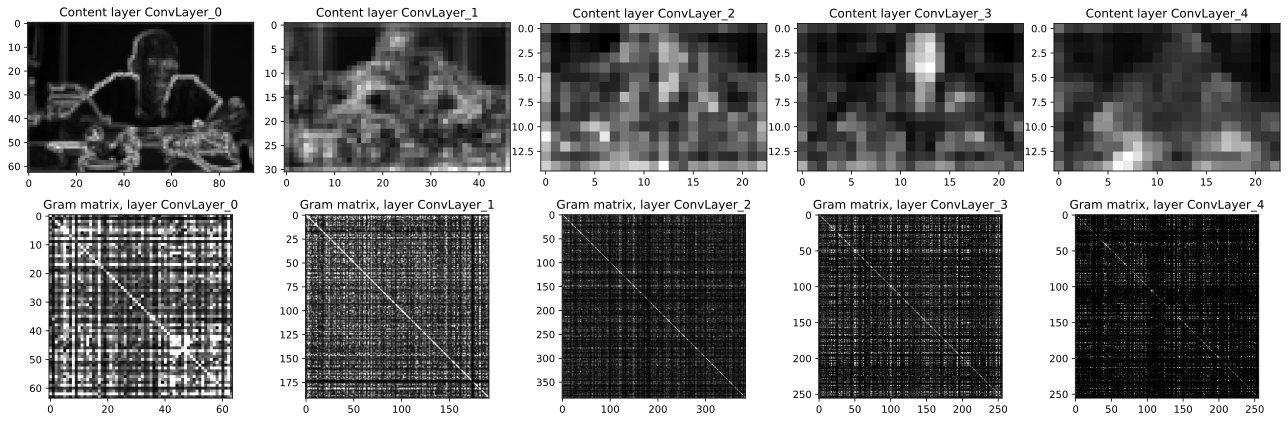

In [19]:
# let's see what the "content" image looks like
contentFeatureMaps, contentFeatureNames = getFeatureMapActs(img4content, alexnet)

fig, axs = plt.subplots(2,5,figsize=(18,6))

for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy(), axis=0 )
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[0,i].imshow(pic, cmap='gray')
    axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))

    # now show the gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

    axs[1,i].imshow(pic, cmap='gray', vmax=.1)
    axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

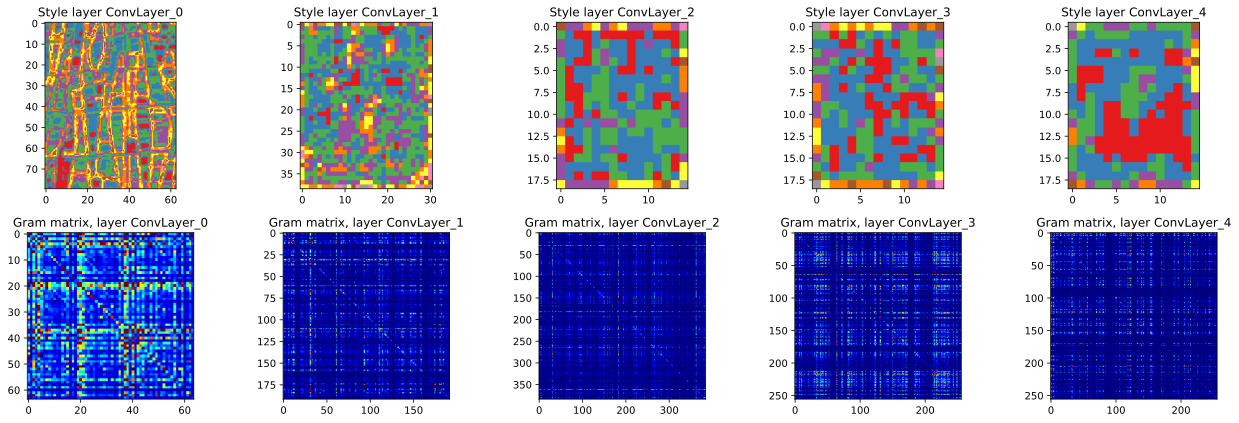

In [20]:
# repeat for the "style" image
styleFeatureMaps, styleFeatureNames = getFeatureMapActs(img4style, alexnet)

fig, axs = plt.subplots(2,5,figsize=(18,6))

for i in range(5):

      # average over all feature maps from this layer, and normalize
     pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
     pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

     axs[0,i].imshow(pic,cmap='Set1')
     axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


     ### now show the gram matrix
     pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
     pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

     axs[1,i].imshow(pic,cmap='jet',vmax=.1)
     axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

## Now for the transfer

In [21]:
# which layers to use
layers4content = ['convLayer_0']
layers4style = ['ConvLayer_0', 'ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4']
weights4style = [1,.8,.6,.4,.2]

In [22]:
# make a copy of the target image and push to GPU
target = img4content.clone()
target.requires_grad=True
target = target.to(device)
styleScaling = 5e4

numepochs = 1500

optimizer = torch.optim.RMSprop([target], lr=.001)

for epochi in range(numepochs):

    # extract the target feature maps
    targetFeatureMaps, targetFeatureNames = getFeatureMapActs(target, alexnet)

    # initialize the individual loss components
    styleLoss = 0
    contentLoss = 0

    # loop over layers
    for layeri in range(len(targetFeatureNames)):

        # compute the content loss
        if targetFeatureNames[layeri] in layers4content:
            contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )

        # compute the style loss
        if targetFeatureNames[layeri] in layers4style:

            # Gram matrices
            Gtarget = gram_matrix(targetFeatureMaps[layeri])
            Gstyle = gram_matrix(styleFeatureMaps[layeri])

            # compute their loss (de-weighted with increasing depth)
            styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

    # combined loss
    combiloss = styleScaling * styleLoss + contentLoss

    # finally ready for backprop!
    optimizer.zero_grad()
    combiloss.backward()
    optimizer.step()

## Let's have a looksie!

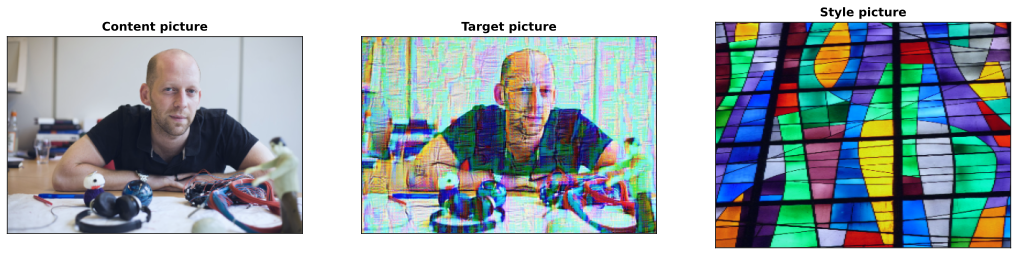

In [23]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()